In [30]:
import os
import cv2  
import numpy as np
import tqdm as tqdm
from PIL import Image


REBUILD_DATA = False

In [44]:
class DataBuild():
    IMG_SIZE = 80
    LABELS = {'NORMAL':0,'PNEUMONIA':1}
    normal_count = 0
    pneumonia_count = 0
    training_data = []
    test_data = []

    def make_training_data(self):

        for label in self.LABELS:
            path = os.getcwd()+'/chest_xray/train/' + label
            for dir in tqdm.tqdm(os.listdir(path)):
                try:
                    #print(dir)
                    path_img = os.path.join(path,dir)
                    
                    img = cv2.imread(path_img,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == 'NORMAL':
                        self.normal_count += 1
                    elif label == 'PNEUMONIA':
                        self.pneumonia_count += 1
                except Exception as e:
                    print(str(e))
                    pass       

        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)

        print("NORMAL: ",self.normal_count)
        print("PNEUMONIA: ",self.pneumonia_count)


    def make_test_data(self):

        for label in self.LABELS:
            path = os.getcwd()+'/chest_xray/test/' + label
            for dir in tqdm.tqdm(os.listdir(path)):
                try:
                    #print(dir)
                    path_img = os.path.join(path,dir)
                    
                    img = cv2.imread(path_img,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    
                    self.test_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                except Exception as e:
                    print(str(e))
                    pass       

        np.random.shuffle(self.test_data)
        np.save("test_data.npy",self.test_data)



In [45]:
Data = DataBuild()
if REBUILD_DATA:
    Data.make_training_data()

In [55]:
training_data = np.load('training_data.npy',allow_pickle=True)

5232


[1. 0.]
(80, 80)


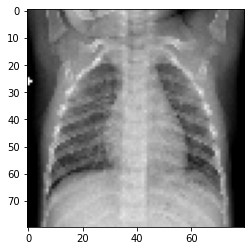

In [34]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1000][0],cmap='gray')
print(training_data[1000][1])
print(training_data[0][0].shape)
plt.show()

In [35]:
import torch

X = torch.tensor([i[0] for i in training_data]).view(-1,80,80)
X = X/255.0
y = torch.tensor([i[1] for i in training_data])

In [36]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float64)
    self.y = torch.tensor(y,dtype=torch.float64)
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X,y)

<ipython-input-36-23f42a8619c7>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float64)
<ipython-input-36-23f42a8619c7>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float64)


In [57]:
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader

class_weights = [1,3]
sample_weights = [0] * len(training_data)

for i,(x,y) in enumerate(trainset):
    class_weight = class_weights[int(y[0])]
    sample_weights[i] = class_weight

sampler = WeightedRandomSampler(sample_weights,num_samples=len(sample_weights),replacement=True)


trainloader = DataLoader(trainset,batch_size=5,sampler=sampler,shuffle=False)

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32,64,5)
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64,128,5)
        self.pool3 = nn.MaxPool2d((2,2))
    
        
        self.fc2 = nn.Linear(512,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = x.flatten(start_dim=1)
        
        self.fc1 = nn.Linear(x.shape[1],512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x,dim=1)

net = Net()
net.forward(torch.rand(1,1,80,80))


tensor([[0.5049, 0.4951]], grad_fn=<SoftmaxBackward>)

In [59]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()

EPOCHS = 1

for epoch in range(EPOCHS):
    for X,y in tqdm.tqdm(trainloader):
        #print(i,i+BATCH_SIZE)
        X = torch.tensor(X.clone().detach(),dtype=torch.float32)
        y = torch.tensor(y.clone().detach(),dtype=torch.float32)

        net.zero_grad()

        outputs = net(X.view(-1,1,80,80))
        loss = loss_function(outputs,y)
        loss.backward()
        optimizer.step()
print(loss)

  0%|          | 0/1047 [00:00<?, ?it/s]<ipython-input-59-26d3d45530bb>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X.clone().detach(),dtype=torch.float32)
<ipython-input-59-26d3d45530bb>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y.clone().detach(),dtype=torch.float32)
100%|██████████| 1047/1047 [02:45<00:00,  6.32it/s]tensor(0.1643, grad_fn=<MseLossBackward>)



In [60]:
Data.make_test_data()
test_data = np.load('test_data.npy',allow_pickle=True)

100%|██████████| 390/390 [00:02<00:00, 130.02it/s]
C:\Users\feder\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [65]:
correct = 0
total = 0

test_x = torch.tensor([i[0] for i in test_data])
test_x = test_x/255.0
test_y = torch.tensor([i[1] for i in test_data])

with torch.no_grad():
    for i in tqdm.tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1,1,80,80))[0]
       
        predicted_class = torch.argmax(net_out)
        
        if real_class == predicted_class:
            correct += 1
        total +=1
print("\nAccuracy: ",round(correct/total,3))

100%|██████████| 1872/1872 [01:09<00:00, 26.78it/s]

Accuracy:  0.806


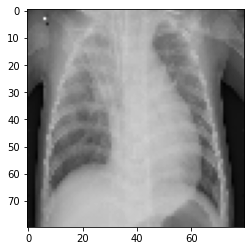

Prediction =  tensor(1)
Real =  tensor(1)


In [87]:
import random
i = random.randrange(0,1046)
Img_t = test_x[i]

plt.imshow(Img_t,cmap='gray')
plt.show()

print("Prediction = ",torch.argmax(net(Img_t.view(-1,1,80,80))))
print("Real = ",torch.argmax(test_y[i]))